In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
# [https://github.com/metmuseum/openaccess/raw/master/MetObjects.csv]
# (https://github.com/metmuseum/openaccess/raw/master/MetObjects.csv)


In [6]:
path = "Sales_US.csv"
df = pd.read_csv(path,parse_dates = ['Order Date', 'Ship Date'])
df.head(3)

,Category,City,Country/Region,Customer ID,Customer Name,Order Date,Order ID,Postal Code,Product ID,Product Name,...,Ship Status,State,Sub-Category,Days to Ship Actual,Days to Ship Scheduled,Discount,Profit,Quantity,Sales,Sales Forecast
0,Furniture,Henderson,United States,CG-12520,Claire Gute,2020-11-08,CA-2020-152156,42420.0,FUR-BO-10001798,Bush Somerset Collection Bookcase,...,Shipped On Time,Kentucky,Bookcases,3,3,0.00%,$42,2,$262,$392
1,Furniture,Henderson,United States,CG-12520,Claire Gute,2020-11-08,CA-2020-152156,42420.0,FUR-CH-10000454,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",...,Shipped On Time,Kentucky,Chairs,3,3,0.00%,$220,3,$732,"$1,096"
2,Office Supplies,Los Angeles,United States,DV-13045,Darrin Van Huff,2020-06-12,CA-2020-138688,90036.0,OFF-LA-10000240,Self-Adhesive Address Labels for Typewriters b...,...,Shipped Late,California,Labels,4,3,0.00%,$7,2,$15,$22


In [7]:
df.columns

Index(['Category', 'City', 'Country/Region', 'Customer ID', 'Customer Name',
       'Order Date', 'Order ID', 'Postal Code', 'Product ID', 'Product Name',
       'Region', 'Row ID', 'Segment', 'Ship Date', 'Ship Mode', 'Ship Status',
       'State', 'Sub-Category', 'Days to Ship Actual',
       'Days to Ship Scheduled', 'Discount', 'Profit', 'Quantity', 'Sales',
       'Sales Forecast'],
      dtype='object')

In [8]:
def clean_currency(x):
    if isinstance(x, str):
        x = x.strip().replace('$', '').replace(',', '')
        if x.startswith('('):
            x = '-'+ x.strip('()')
    return x

In [9]:
for i in ['Profit', 'Sales', 'Sales Forecast']:
    df[i] = df[i].apply(clean_currency).astype('float')

#### Most profitable sub-category in last 12 month sales

In [10]:
(df[pd.DatetimeIndex(df['Ship Date']).year == 2021][['Sub-Category', 'Profit']]
   .groupby('Sub-Category').agg({'Profit': np.sum})
   .sort_values(by = 'Profit',ascending = False)).index[0]

'Copiers'

#### Visualization of sales per month v/s same month last year sales

In [11]:
twoyrssales_df = df[pd.DatetimeIndex(df['Ship Date']).year >= 2020][['Ship Date', 'State', 'Sales', 'Profit']]
twoyrssales_df['Year'] = pd.DatetimeIndex(twoyrssales_df['Ship Date']).year
twoyrssales_df['Month'] = pd.DatetimeIndex(twoyrssales_df['Ship Date']).month
twoyrssales_df = twoyrssales_df.loc[twoyrssales_df['Year'] < 2022]

In [12]:
twoyrssales_df = twoyrssales_df[['Year', 'Month', 'State', 'Sales']]
twoyrssummary_df = twoyrssales_df.groupby(['Year', 'Month','State']).sum()

In [13]:
twoyrssummary_df

Sales
Year Month State              
2020 1     California   5906.0
           Connecticut   182.0
           Florida       255.0
           Georgia       316.0
           Illinois       38.0
...                        ...
2021 12    Texas        2515.0
           Vermont       205.0
           Virginia     1868.0
           Washington   3325.0
           Wisconsin    1979.0

[681 rows x 1 columns]

In [14]:
twoyrssummary_df = twoyrssummary_df.unstack(level = -3, fill_value = 0)
twoyrssummary_df

Sales        
Year                 2020    2021
Month State                      
1     Alabama         0.0    56.0
      Arizona         0.0   600.0
      California   5906.0  5278.0
      Colorado        0.0   357.0
      Connecticut   182.0     4.0
...                   ...     ...
12    Texas        3680.0  2515.0
      Vermont         0.0   205.0
      Virginia     4062.0  1868.0
      Washington   6855.0  3325.0
      Wisconsin    3744.0  1979.0

[415 rows x 2 columns]

In [15]:
twoyrssummary_df = twoyrssummary_df.Sales.reset_index()
twoyrssummary_df

Year,Month,State,2020,2021
0,1,Alabama,0.0,56.0
1,1,Arizona,0.0,600.0
2,1,California,5906.0,5278.0
3,1,Colorado,0.0,357.0
4,1,Connecticut,182.0,4.0
...,...,...,...,...
410,12,Texas,3680.0,2515.0
411,12,Vermont,0.0,205.0
412,12,Virginia,4062.0,1868.0
413,12,Washington,6855.0,3325.0


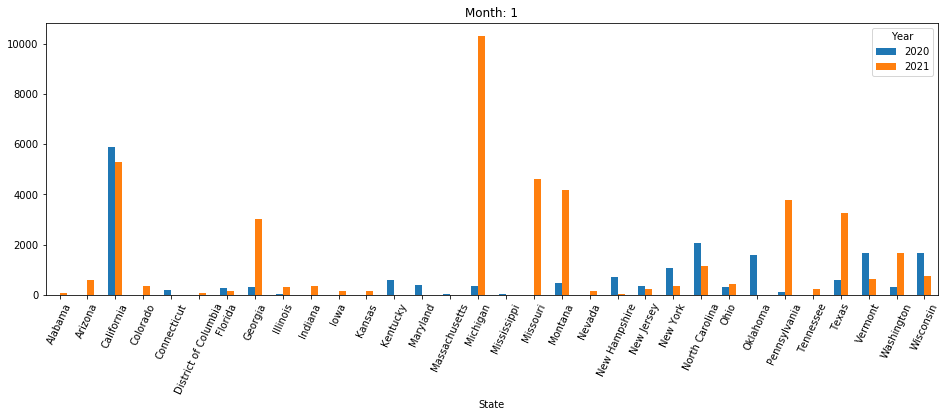

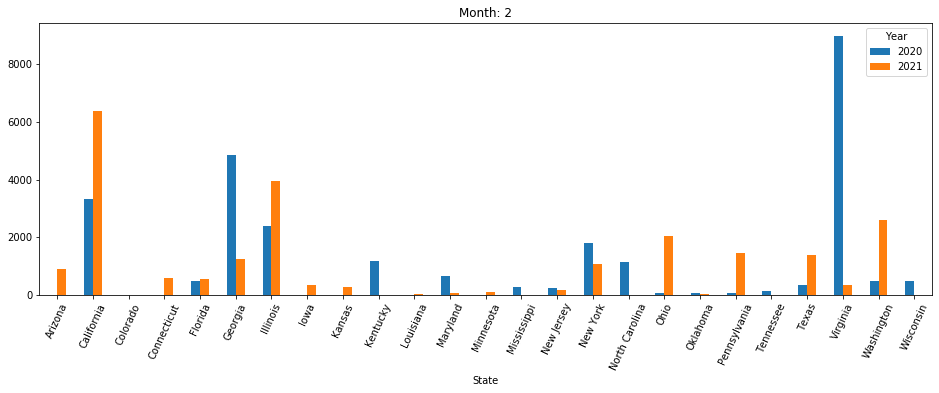

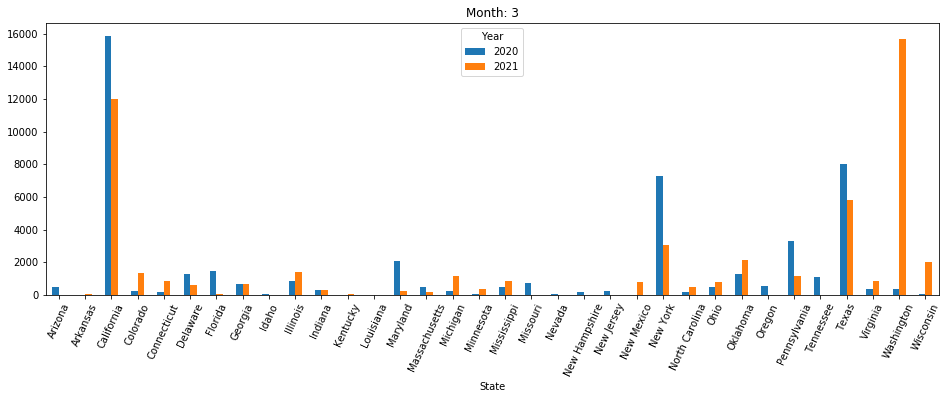

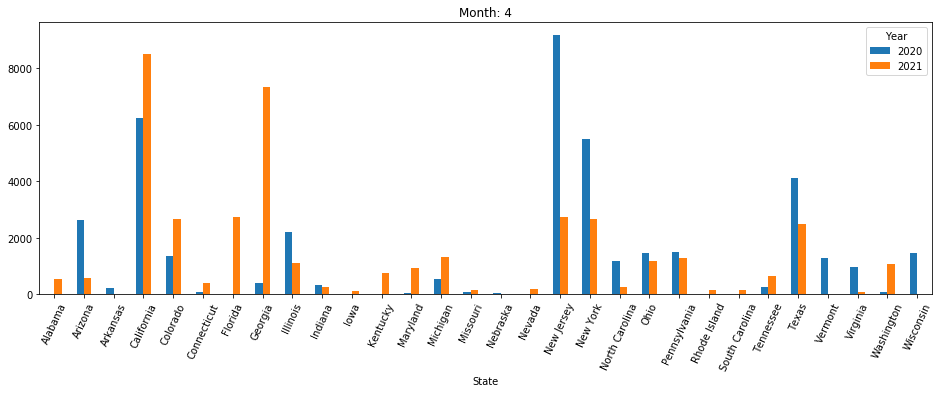

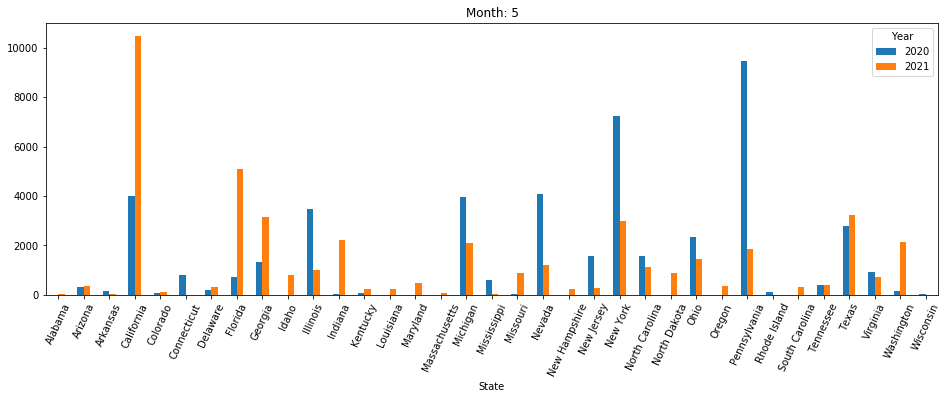

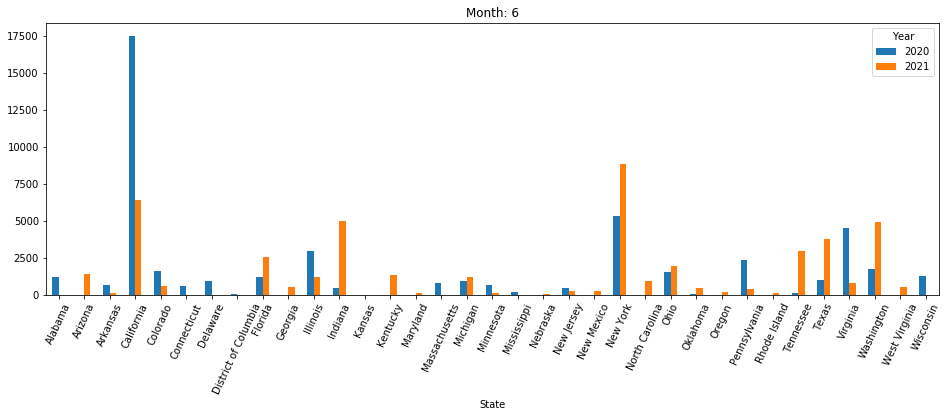

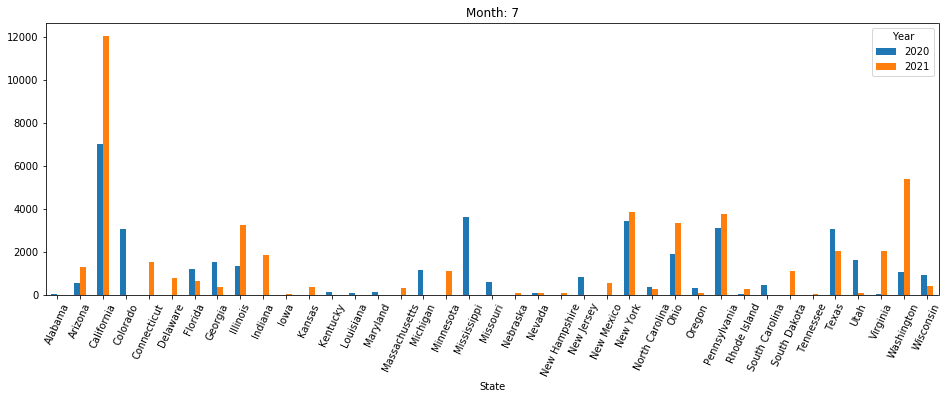

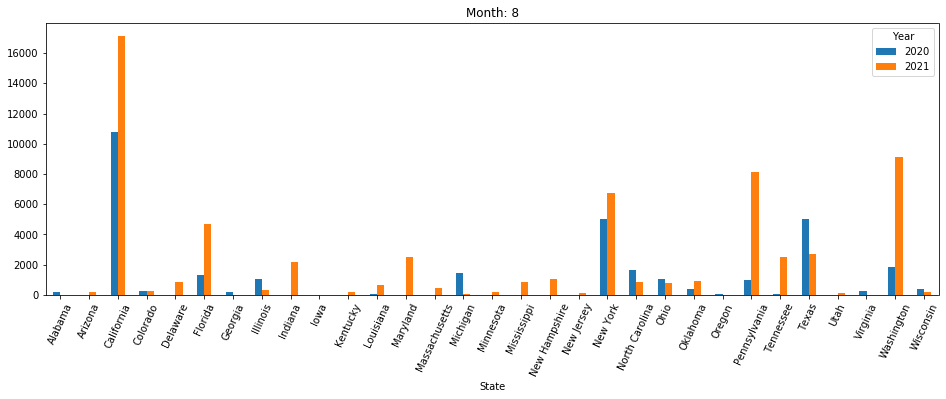

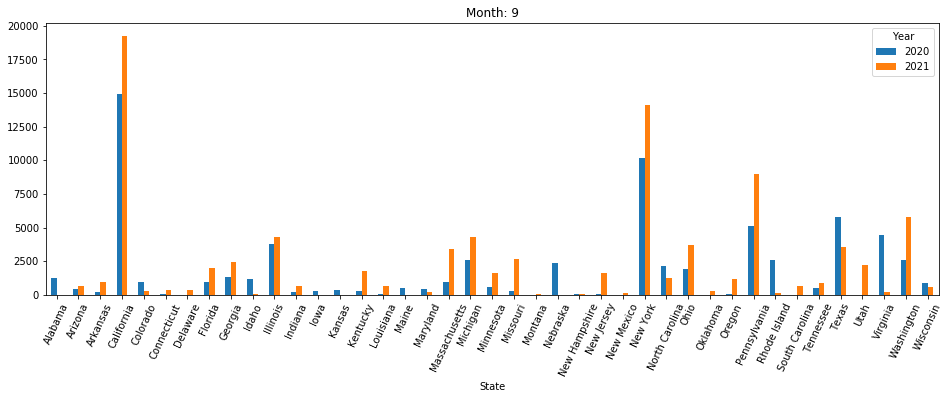

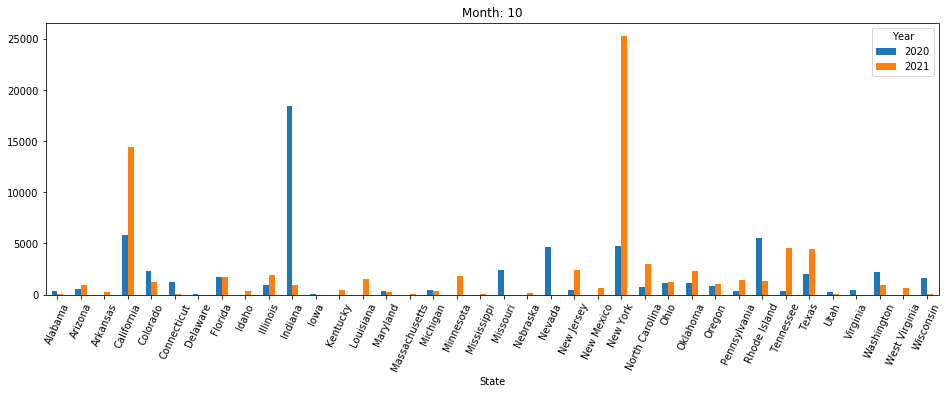

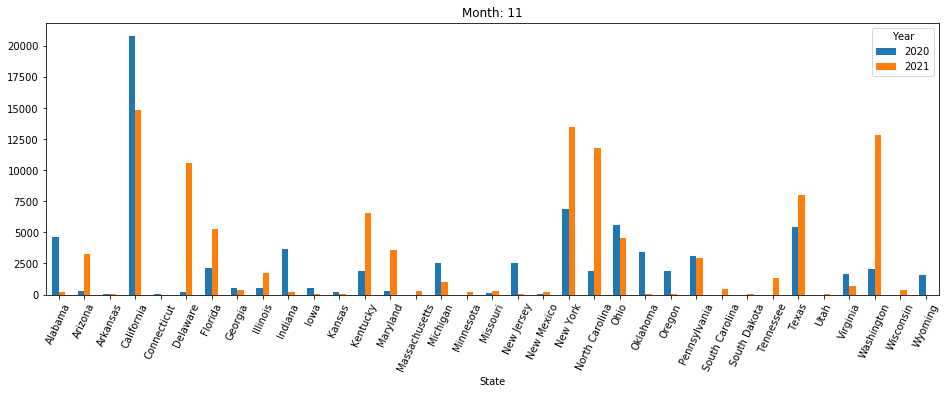

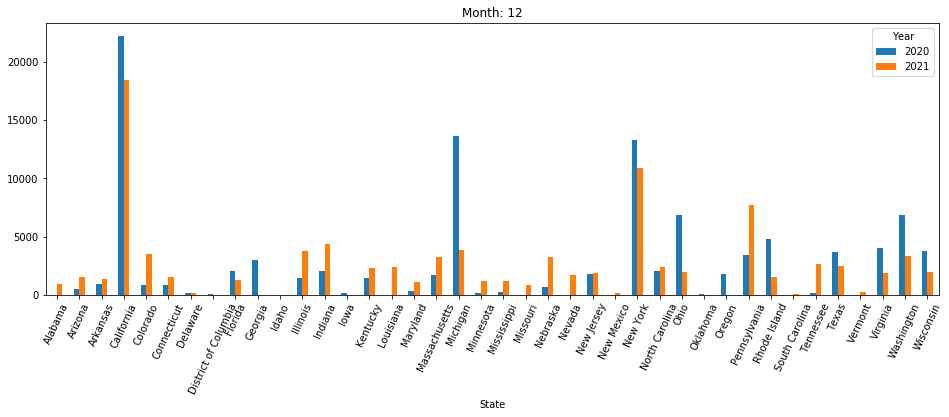

In [16]:
def subplot_by_colval(indf,subplotcol,xcol,ycol,**kwargs):
    colval = indf[subplotcol].sort_values().unique()
    for c in colval:
        querystr = subplotcol+' == '+str(c)
        chart_title = subplotcol+': '+str(c)
        indf.query(querystr).plot(xcol,ycol,title = chart_title, **kwargs)
subplot_by_colval(twoyrssummary_df,'Month','State',[2020,2021],kind = 'bar', figsize = (16,5), fontsize = 10, rot = 65)

#### Churn rate per state
#### if customer doesn't purchase any thing from stores within 180 days form his/her last purchase, then we consider as a 
#### churned customer.

In [17]:
churn_df = df.groupby(['State','Customer ID'])['Ship Date'].max().reset_index()

In [18]:
churn_df['days_from_lastpurchase'] = df['Ship Date'].max() - churn_df['Ship Date']

In [19]:
churn_df['days_from_lastpurchase'] = churn_df['days_from_lastpurchase'].apply( lambda x: x.days) #convert timedelta to int

In [20]:
churn_period = 180
churn_df.loc[churn_df['days_from_lastpurchase'] > churn_period, 'Category'] = 'Churned'
churn_df.loc[churn_df['days_from_lastpurchase'] < churn_period, 'Category'] = 'Survived'

In [21]:
churn_df.head(30)

,State,Customer ID,Ship Date,days_from_lastpurchase,Category
0,Alabama,AH-10465,2021-04-06,274,Churned
1,Alabama,AM-10705,2020-09-23,469,Churned
2,Alabama,AP-10720,2020-05-27,588,Churned
3,Alabama,AS-10225,2018-10-20,1173,Churned
4,Alabama,BF-11080,2018-12-04,1128,Churned
5,Alabama,CA-11965,2021-01-31,339,Churned
6,Alabama,CB-12025,2021-11-20,46,Survived
7,Alabama,DC-12850,2021-06-08,211,Churned
8,Alabama,DH-13075,2019-06-19,931,Churned
9,Alabama,DP-13390,2021-01-13,357,Churned


In [22]:
churn_rate_df = (churn_df[['State','Category', 'days_from_lastpurchase']].groupby(['State','Category']).agg(['count'])
            .reset_index())
churn_rate_df

,State,Category,days_from_lastpurchase
,,,count
0,Alabama,Churned,30
1,Alabama,Survived,4
2,Arizona,Churned,79
3,Arizona,Survived,21
4,Arkansas,Churned,21
...,...,...,...
90,West Virginia,Churned,1
91,West Virginia,Survived,1
92,Wisconsin,Churned,39


In [23]:
churn_rate_df = churn_rate_df.pivot(columns='Category',values = ['days_from_lastpurchase'],index='State').fillna(0)
churn_rate_df

days_from_lastpurchase         
Category                            Churned Survived
State                                               
Alabama                                30.0      4.0
Arizona                                79.0     21.0
Arkansas                               21.0      6.0
California                            388.0    189.0
Colorado                               59.0     16.0
Connecticut                            35.0      8.0
Delaware                               36.0      7.0
District of Columbia                    4.0      0.0
Florida                               138.0     43.0
Georgia                                67.0     16.0
Idaho                                   8.0      3.0
Illinois                              177.0     60.0
Indiana                                55.0     15.0
Iowa                                   13.0      4.0
Kansas                                 11.0      3.0
Kentucky                               40.0     18.0
Louisiana                              15.0      6.0
Maine                                   3.0      0.0
Maryland                               33.0     12.0
Massachusetts                          44.0     17.0
Michigan                               88.0     18.0
Minnesota                              27.0     15.0
Mississippi                            20.0      5.0
Missouri                               22.0      6.0
Montana                                 7.0      1.0
Nebraska                               17.0      6.0
Nevada                                 22.0      1.0
New Hampshire                          14.0      3.0
New Jersey                             48.0     13.0
New Mexico                             14.0      8.0
New York                              306.0    108.0
North Carolina                         93.0     28.0
North Dakota                            1.0      1.0
Ohio                                  150.0     52.0
Oklahoma                               27.0      7.0
Oregon                                 40.0     11.0
Pennsylvania                          192.0     64.0
Rhode Island                           17.0      7.0
South Carolina                         15.0      4.0
South Dakota                            2.0      3.0
Tennessee                              61.0     23.0
Texas                                 275.0     95.0
Utah                                   19.0      7.0
Vermont                                 4.0      1.0
Virginia                               93.0     14.0
Washington                            164.0     60.0
West Virginia                           1.0      1.0
Wisconsin                              39.0     13.0
Wyoming                                 1.0      0.0

In [24]:
churn_rate_df = churn_rate_df['days_from_lastpurchase'].reset_index()

In [26]:
churn_rate_df['churn_rate'] = (round((churn_rate_df['Churned'] *100) / (churn_rate_df['Churned'] + 
                                                                        churn_rate_df['Survived']),0))
churn_rate_df.sort_values(by='churn_rate', ascending=True)

Category,State,Churned,Survived,churn_rate
39,South Dakota,2.0,3.0,40.0
32,North Dakota,1.0,1.0,50.0
46,West Virginia,1.0,1.0,50.0
21,Minnesota,27.0,15.0,64.0
29,New Mexico,14.0,8.0,64.0
3,California,388.0,189.0,67.0
15,Kentucky,40.0,18.0,69.0
37,Rhode Island,17.0,7.0,71.0
16,Louisiana,15.0,6.0,71.0
19,Massachusetts,44.0,17.0,72.0


In [27]:
churn_rate_df[['Churned','Survived']].sum()

Category
Churned     3035.0
Survived    1023.0
dtype: float64

#### Boxplot of churned customers per state

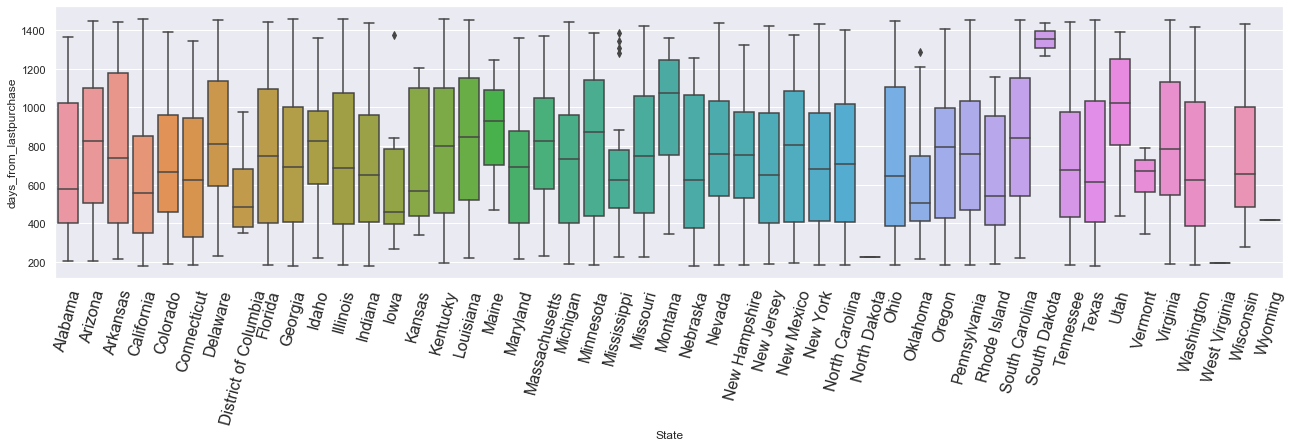

In [28]:
#churn_df = churn_df[['State', 'days_from_lastpurchase','Category']]
churn_pos_df = churn_df.loc[churn_df['Category'] == 'Churned']
sns.set(rc={'figure.figsize':(22, 5)})
x = sns.boxplot(data = churn_pos_df, x ='State',y ='days_from_lastpurchase')
x.set_xticklabels(labels = churn_pos_df.State.unique(), rotation = 75,fontsize = 16);

#### Boxplot Visualization of Survived customers

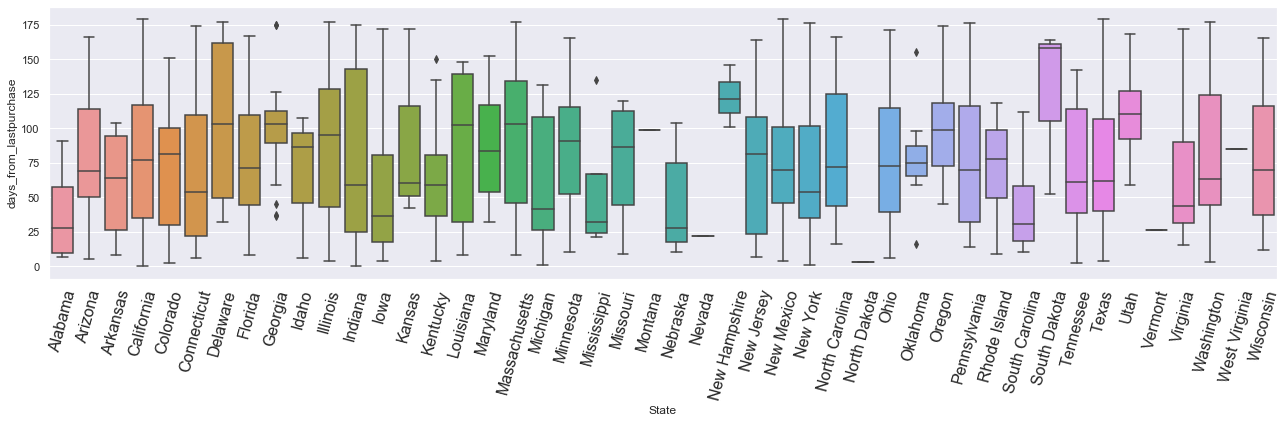

In [29]:
churn_neg_df = churn_df.loc[churn_df['Category'] == 'Survived']
sns.set(rc={'figure.figsize':(22, 5)})
x = sns.boxplot(data = churn_neg_df, x ='State',y ='days_from_lastpurchase')
x.set_xticklabels(labels = churn_neg_df.State.unique(), rotation = 75,fontsize = 16);

#### Customer Lifetime Value (CLV)

#### By Sales

In [30]:
(df.groupby(['Customer ID','Customer Name']).agg({'Sales':np.sum, 'Profit':np.sum}).
 sort_values(by = 'Sales',ascending = False))

,,Sales,Profit
Customer ID,Customer Name,,
SM-20320,Sean Miller,25042.0,-1981.0
TC-20980,Tamara Chand,19050.0,8983.0
RB-19360,Raymond Buch,15117.0,6976.0
TA-21385,Tom Ashbrook,14596.0,4704.0
AB-10105,Adrian Barton,14476.0,5445.0
...,...,...,...
RS-19870,Roy Skaria,22.0,9.0
CJ-11875,Carl Jackson,17.0,2.0
MG-18205,Mitch Gastineau,16.0,-1.0


#### By Profit

In [31]:
(df.groupby(['Customer ID','Customer Name']).agg({'Sales':np.sum, 'Profit':np.sum}).
 sort_values(by = 'Profit',ascending = False))

,,Sales,Profit
Customer ID,Customer Name,,
TC-20980,Tamara Chand,19050.0,8983.0
RB-19360,Raymond Buch,15117.0,6976.0
SC-20095,Sanjit Chand,14145.0,5756.0
HL-15040,Hunter Lopez,12875.0,5623.0
AB-10105,Adrian Barton,14476.0,5445.0
...,...,...,...
HG-14965,Henry Goldwyn,3250.0,-2797.0
SR-20425,Sharelle Roach,3234.0,-3336.0
LF-17185,Luke Foster,3931.0,-3583.0


## Most profitable category and sub-category by segments

In [32]:
(df.groupby(['Category', 'Sub-Category','Segment' ]).agg({'Profit': np.sum}).sort_values(by='Profit',
                                                                                                           ascending=False))

Profit
Category        Sub-Category Segment             
Technology      Copiers      Consumer     24084.0
                Phones       Consumer     23828.0
                Accessories  Consumer     20737.0
                Copiers      Corporate    18990.0
Office Supplies Binders      Consumer     17983.0
                Paper        Consumer     15542.0
Furniture       Chairs       Consumer     13234.0
Technology      Accessories  Corporate    12705.0
                Copiers      Home Office  12544.0
                Phones       Corporate    11758.0
Office Supplies Paper        Corporate    10357.0
                Storage      Corporate     9130.0
Technology      Phones       Home Office   8906.0
                Accessories  Home Office   8490.0
Furniture       Chairs       Corporate     8343.0
Office Supplies Paper        Home Office   8154.0
Furniture       Furnishings  Consumer      7921.0
Office Supplies Appliances   Corporate     7429.0
                Storage      Consumer      7107.0
                Appliances   Consumer      6980.0
                Binders      Corporate     6378.0
                             Home Office   5839.0
                Storage      Home Office   5043.0
Furniture       Chairs       Home Office   5009.0
Office Supplies Appliances   Home Office   3723.0
Furniture       Furnishings  Corporate     3508.0
Office Supplies Art          Consumer      3457.0
                Envelopes    Consumer      3263.0
                Labels       Consumer      3081.0
                Envelopes    Corporate     2571.0
Technology      Machines     Consumer      2142.0
Office Supplies Art          Corporate     2008.0
                Labels       Corporate     1766.0
Furniture       Furnishings  Home Office   1641.0
Office Supplies Envelopes    Home Office   1122.0
                Art          Home Office   1065.0
                Labels       Home Office    711.0
Technology      Machines     Corporate      703.0
Furniture       Bookcases    Corporate      638.0
Office Supplies Fasteners    Consumer       581.0
Technology      Machines     Home Office    542.0
Office Supplies Supplies     Corporate      342.0
Furniture       Bookcases    Home Office    322.0
Office Supplies Fasteners    Corporate      252.0
                Supplies     Home Office    130.0
                Fasteners    Home Office    119.0
                Supplies     Consumer     -1659.0
Furniture       Tables       Home Office  -3091.0
                Bookcases    Consumer     -4439.0
                Tables       Corporate    -4913.0
                             Consumer     -9729.0

#### Visualization of sold products per month v/s same month last year sold products

In [70]:
soldproducts_df = (df.loc[(pd.DatetimeIndex(df['Ship Date']).year < 2022) & (pd.DatetimeIndex(df['Ship Date']).year > 2019)]
 [['State','Product ID','Quantity', 'Ship Date']])

In [71]:
#soldproducts_df['Year'] = pd.DatetimeIndex(soldproducts_df['Ship Date']).year
soldproducts_df['Year'] = soldproducts_df['Ship Date'].apply( lambda x : x.strftime('%Y'))
soldproducts_df['Month'] = pd.DatetimeIndex(soldproducts_df['Ship Date']).month

In [72]:
soldproducts_df

,State,Product ID,Quantity,Ship Date,Year,Month
0,Kentucky,FUR-BO-10001798,2,2020-11-11,2020,11
1,Kentucky,FUR-CH-10000454,3,2020-11-11,2020,11
2,California,OFF-LA-10000240,2,2020-06-16,2020,6
12,North Carolina,OFF-PA-10002365,3,2021-04-20,2021,4
13,Washington,OFF-BI-10003656,3,2020-12-10,2020,12
...,...,...,...,...,...,...
9988,Georgia,TEC-PH-10004006,5,2021-11-21,2021,11
9990,California,FUR-FU-10000747,2,2021-03-03,2021,3
9991,California,TEC-PH-10003645,2,2021-03-03,2021,3
9992,California,OFF-PA-10004041,4,2021-03-03,2021,3


In [73]:
soldproducts_df = soldproducts_df.groupby(['Year', 'Month', 'State']).agg({'Quantity': np.sum})

In [74]:
soldproducts_df = soldproducts_df.unstack(level = -3).fillna(0).reset_index()

In [75]:
soldproducts_df.columns = ['_'.join(c) for c in soldproducts_df.columns.values]

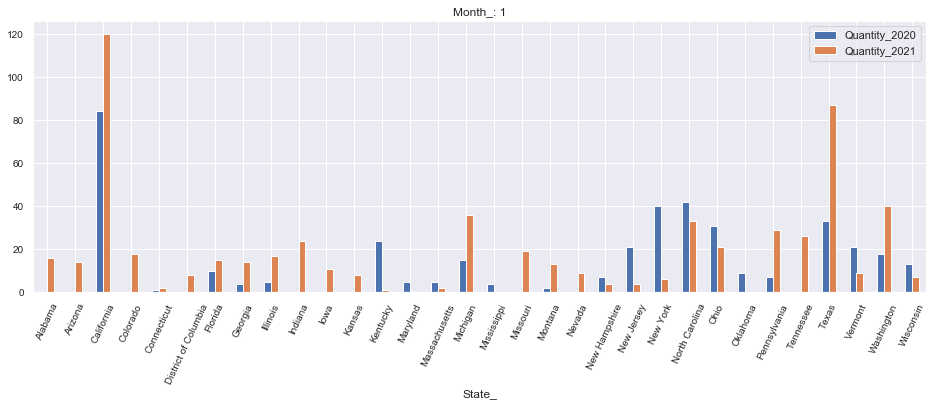

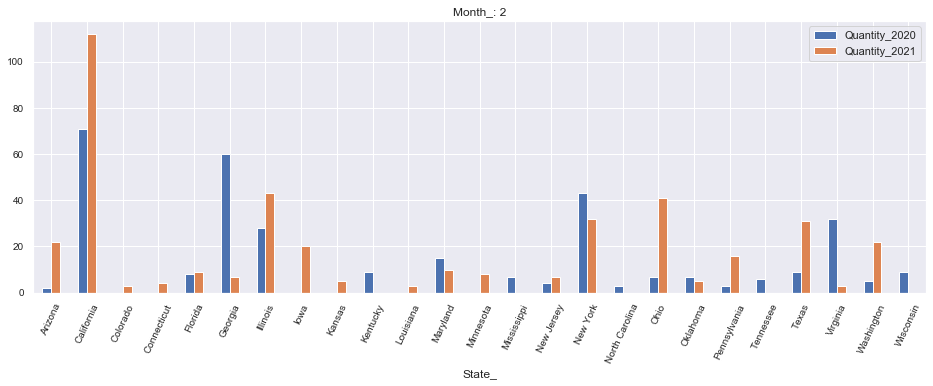

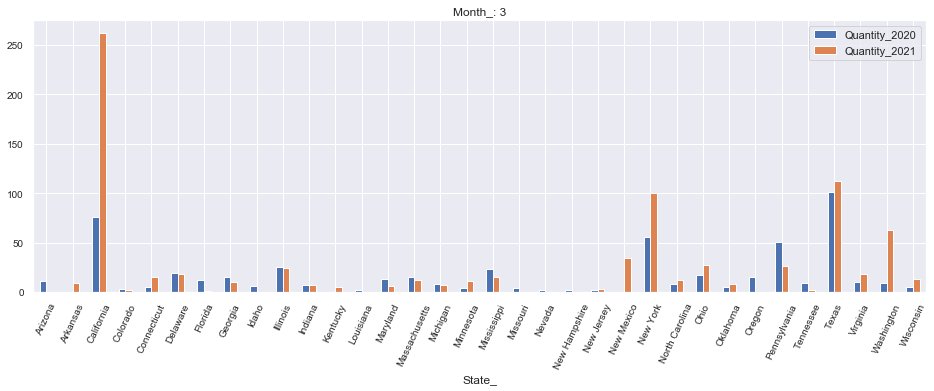

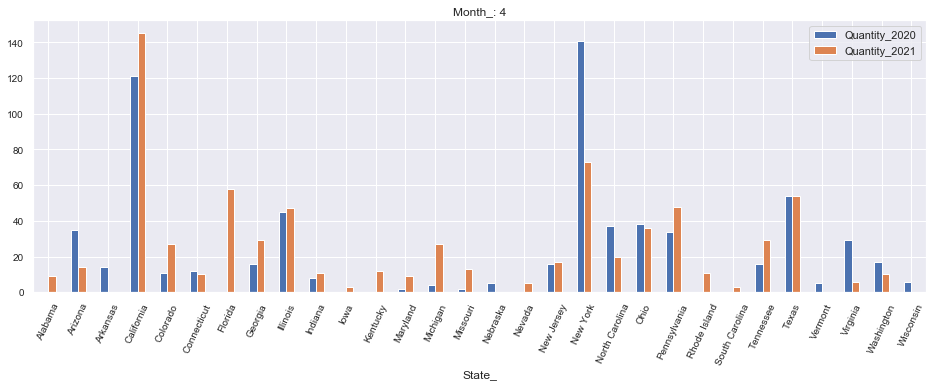

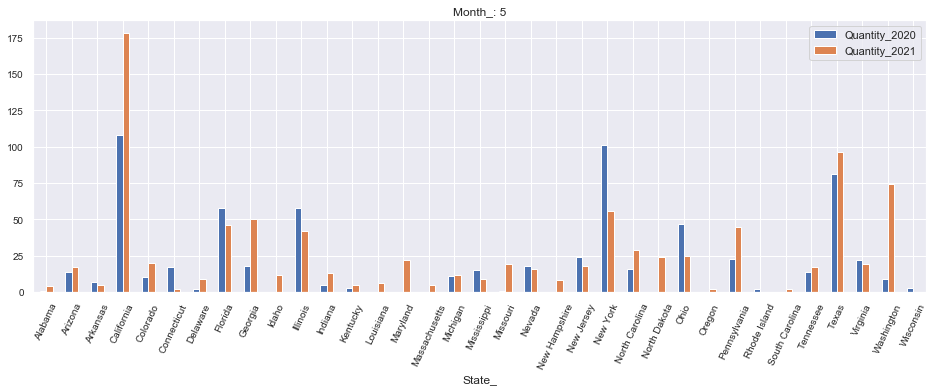

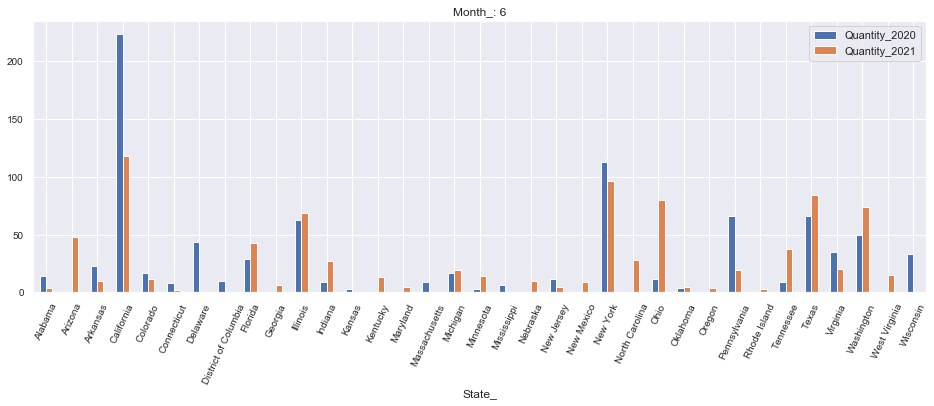

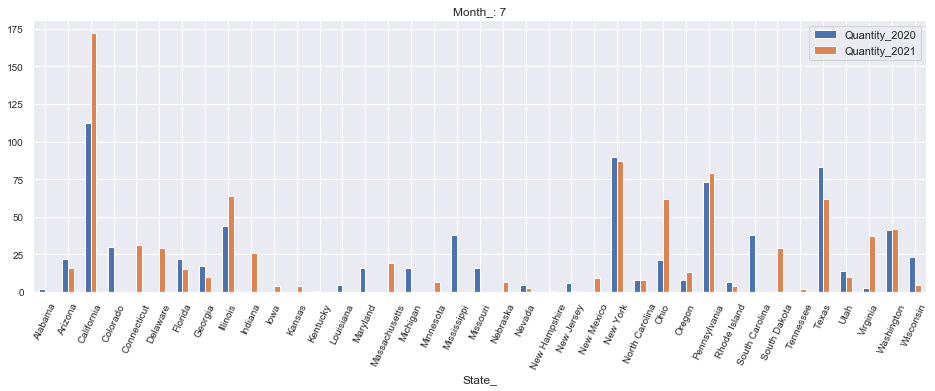

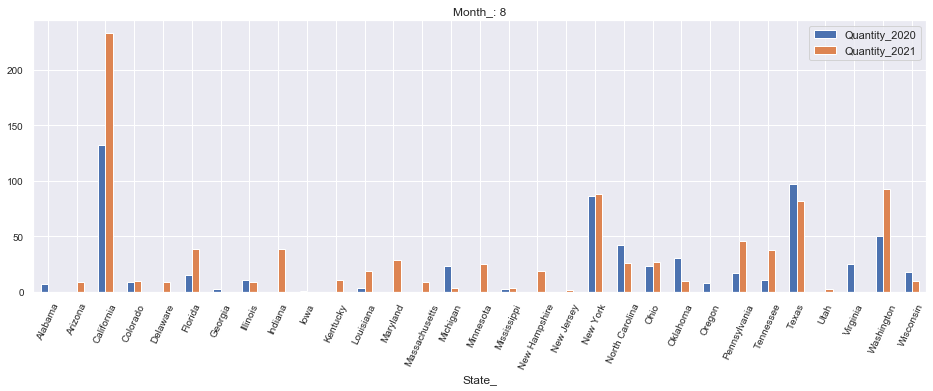

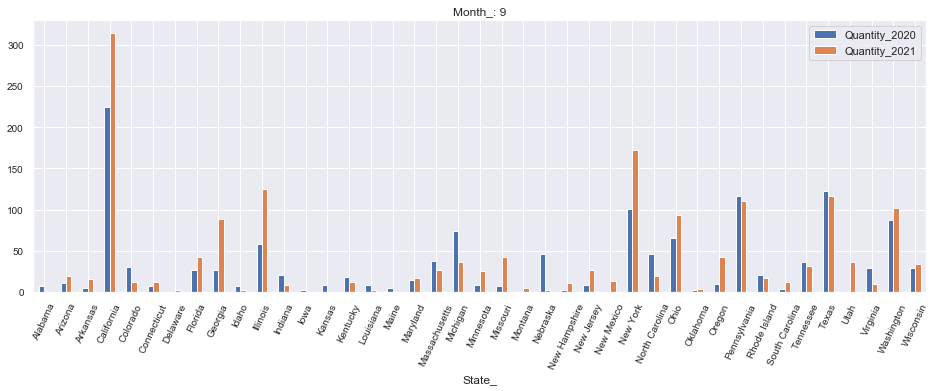

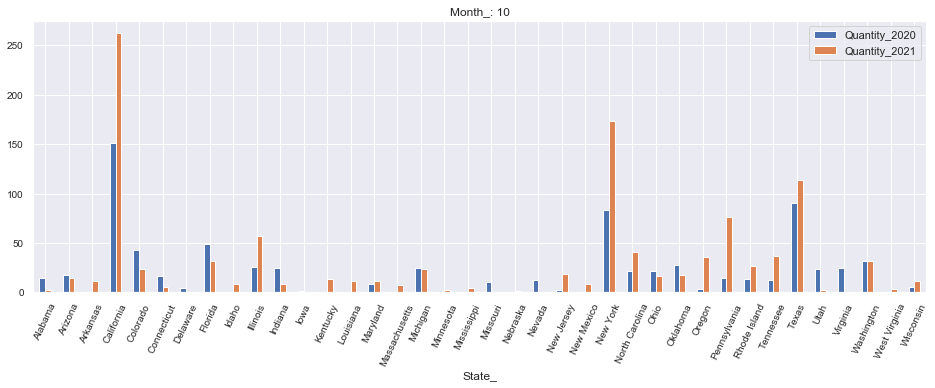

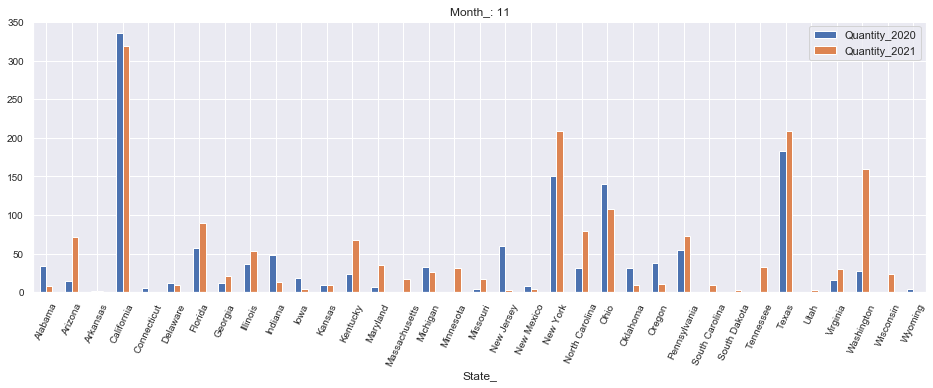

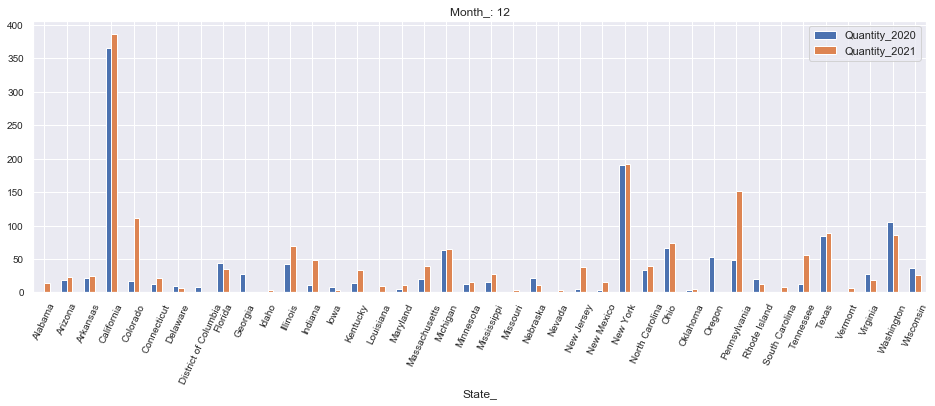

In [76]:
(subplot_by_colval(soldproducts_df,'Month_','State_',['Quantity_2020','Quantity_2021'],kind = 'bar', figsize = (16,5),
                   fontsize = 10, rot = 65))